# QNN for VLDS Dataset 100
## Prepare data

In [4]:
import concurrent
import multiprocessing
import time

import pandas as pd
from IPython.core.display_functions import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM, SLSQP
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal, PauliFeatureMap
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


## Provide configuration options for the learning process
---

In [5]:
RANDOM_SEED = 42
SHOTS = 1024
TRAIN_DATA_SPLIT = 0.75
FOLDS = 10

## Prepare and analyze dataset
---

In [6]:
df = pd.read_csv('datasets/vlds_100.csv', index_col=0)
df.count()

feature_1    100
feature_2    100
feature_3    100
feature_4    100
label        100
dtype: int64

In [7]:
display(df)

,feature_1,feature_2,feature_3,feature_4,label
0,24.0,0.0,16.0,8.0,1.0
1,13.0,2.0,16.0,19.0,1.0
2,14.0,1.0,20.0,15.0,1.0
3,23.0,1.0,14.0,6.0,1.0
4,12.0,0.0,11.0,23.0,1.0
...,...,...,...,...,...
95,11.0,15.0,9.0,14.0,0.0
96,24.0,5.0,26.0,16.0,1.0
97,13.0,1.0,19.0,10.0,1.0
98,15.0,1.0,13.0,14.0,1.0


In [8]:
print(f'Rows with label = 1: #{df.where(df["label"] == 1.0)["label"].count()}')
print(f'Rows with label = 0: #{df.where(df["label"] == 0.0)["label"].count()}')

feature_dimension = df.shape[1] - 1
print(f"Feature dimension: {feature_dimension}")

Rows with label = 1: #72
Rows with label = 0: #28
Feature dimension: 4


In [9]:
# Split the data into training and test sets
all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=TRAIN_DATA_SPLIT, random_state=RANDOM_SEED)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Setup quantum circuit
---

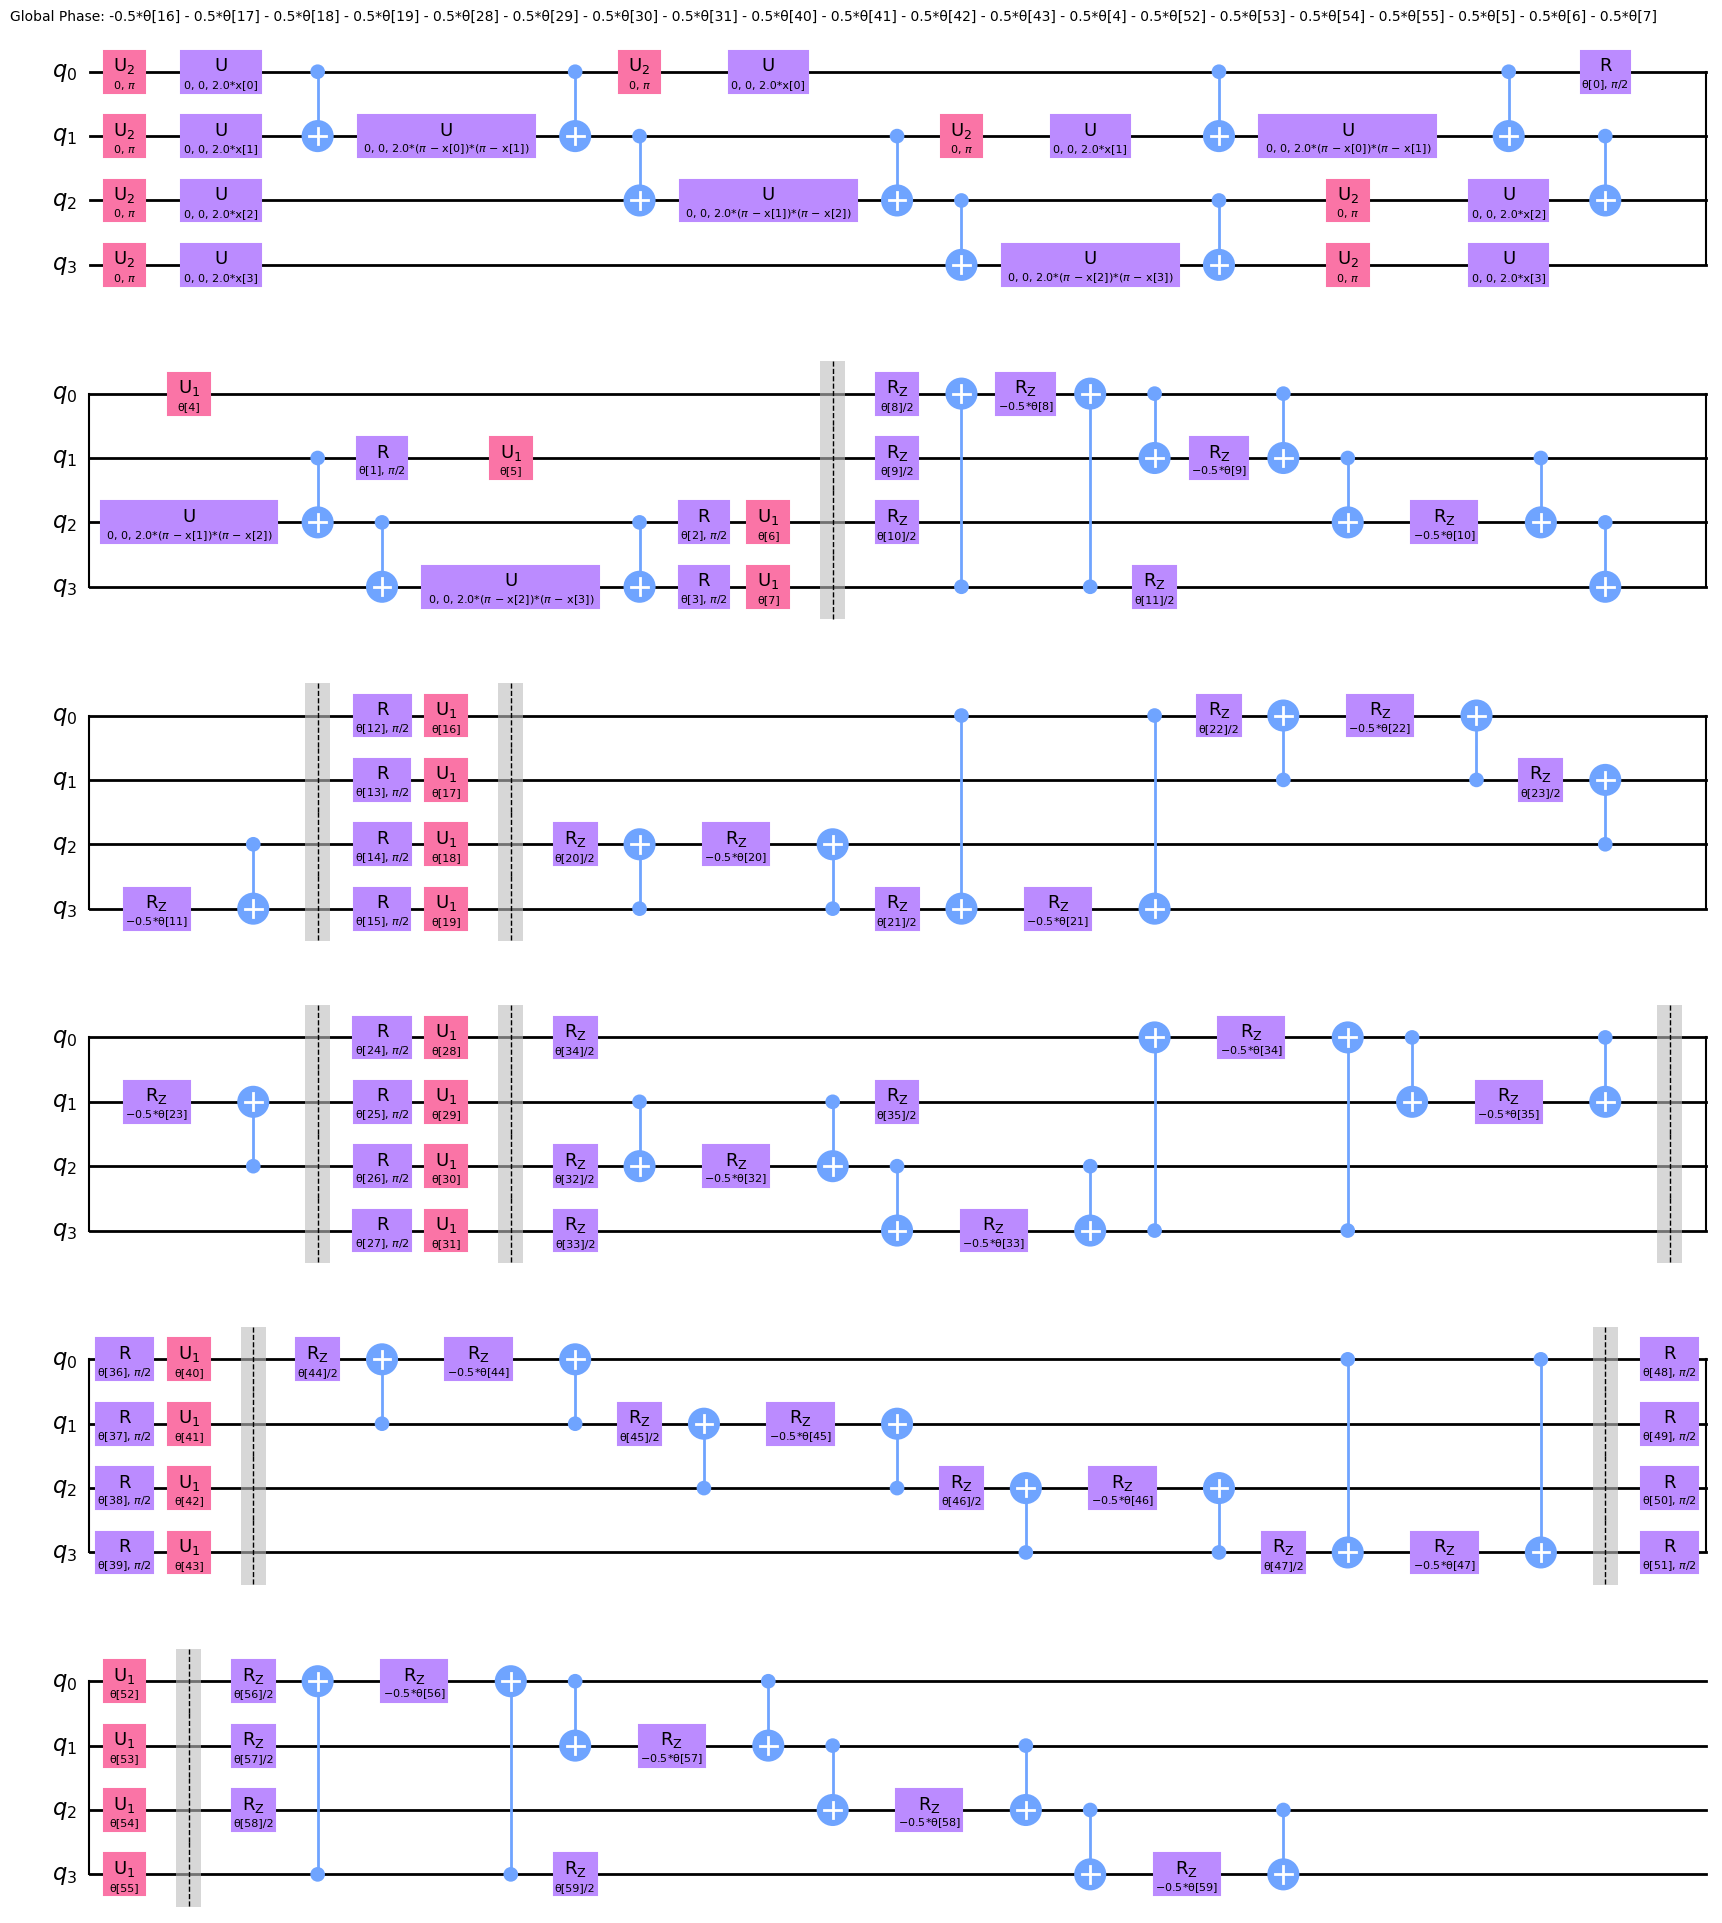

In [10]:
algorithm_globals.random_seed = RANDOM_SEED
quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), shots=SHOTS)

feature_map = ZZFeatureMap(feature_dimension=feature_dimension, entanglement='linear')
# feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=5, paulis=['Z', 'XX'])
# ansatz = RealAmplitudes(num_qubits=feature_map.num_qubits, insert_barriers=True, reps=5)
# ansatz = TwoLocal(num_qubits=feature_map.num_qubits,  reps=5, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', insert_barriers=True, skip_final_rotation_layer=False)
ansatz = TwoLocal(num_qubits=feature_map.num_qubits,  reps=5, rotation_blocks=['ry', 'rz'], entanglement_blocks='crz', entanglement= 'sca', insert_barriers=True, skip_final_rotation_layer=True)
qc = QuantumCircuit(ansatz.num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.decompose().decompose().draw(output='mpl')

In [3]:
def parity(x):
    # return "{:b}".format(x)[0] == '1'
    return "{:b}".format(x).count("1") % 2


sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=2 ** qc.num_qubits,
    interpret=parity,
)

NameError: name 'SamplerQNN' is not defined

In [ ]:
objective_func_vals = []

def callback_graph(_weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(True)
    plt.show()

def callback_print(_weights, obj_func_eval):
    clear_output(wait=True)
    #objective_func_vals.append(obj_func_eval)
    print(obj_func_eval)

models = [
    NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=100),
    # optimizer=ADAM(maxiter=500),
    # optimizer=SLSQP(maxiter=250),
    callback=callback_print
    ) for fold in range(FOLDS)
]

futures = []
start_time = time.time()
end_times = []


# Train the model
k_fold = KFold(n_splits=10)
with concurrent.futures.ThreadPoolExecutor() as executor:
    for i, (train_index, test_index) in enumerate(k_fold.split(train_features)):
        model = models[i]
        current_train_features = train_features.iloc[train_index]
        current_train_labels = train_labels.iloc[train_index]
        futures.append(executor.submit(model.fit, current_train_features, current_train_labels))
        futures[i].add_done_callback(lambda _: end_times.append(time.time() - start_time))
    executor.shutdown(wait=True)
    models = [future.result() for future in futures]




range(0, 239) [0.5193695330124342, 0.5256304302330045, 0.517606208879157, 0.5107098490187881, 0.5235375972107044, 0.4927804991522426, 0.493942711849092, 0.4912947014439153, 0.47915319760426145, 0.4958455049786329, 0.48374077634406293, 0.4789553296739223, 0.48224300719087304, 0.4663470181071912, 0.48300236524457213, 0.46789859694048064, 0.4624340791761051, 0.47718921607024056, 0.477273223573923, 0.47587872941506365, 0.4729028805018293, 0.47613276902928087, 0.47491000322680194, 0.4624102294510339, 0.46234460662207827, 0.48947120166274366, 0.47329797609608726, 0.47551969064230754, 0.4767883515622824, 0.4681102882196886, 0.4736723758399031, 0.4824906616737459, 0.4616591297307078, 0.47114546316742956, 0.4668957974807292, 0.475451520410895, 0.46871573171487524, 0.4657008493146335, 0.4736332863543141, 0.4766341981290496, 0.46164767273083407, 0.48015712408743966, 0.48045208401206885, 0.4912591103949856, 0.4923244069683687, 0.461647672730834, 0.46164767273083407, 0.46164767273083396, 0.46164767

In [ ]:
scores = []

for model in models:
    scores.append(model.score(test_features, test_labels))

print(f"Scores: {scores}")
print(f'Times: {end_times}')



NameError: name 'models' is not defined

In [ ]:
# Non normalized: Accuracy: 0.676
# Normalized: Accuracy: 0.572
# V2 non normalized: Accuracy: 0.584
# V2 normalized: Accuracy: 0.58




## Run on Cloud Quantum Computer
---

In [ ]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

max_score = 0
max_index = 0
for index, score in enumerate(scores):
    print(index, score)
    if score > max_score:
        max_score = score
        max_index = index


IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='zhaw-1')
backend = least_busy(provider.backends(simulator=False))
print(f"Chosen backend: {backend}")
models[max_index].quantum_instance = QuantumInstance(backend, shots=1024)
score = model.score(test_features, test_labels)
print(f"Quantum score: {score}")

NameError: name 'scores' is not defined